# Segmenting and Clustering Neighbourhoods Toronto
This notebook will be used for the IBM Data Science Professional Certificate week 3 assignment

#### Setting up BeautifulSoup 

In [3]:
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urllib.request.urlopen(url)

In [5]:
soup = BeautifulSoup(page, 'lxml')

#### Scraping data from Wikipedia into a DataFrame

In [6]:
all_tables = soup.find_all('table')

In [7]:
right_table = soup.find('table', class_ = 'wikitable sortable')

In [8]:
# Initialises column lists
Postal_Code = []
Borough = []
Neighbourhood = []

# Scrapes table and inputs data into the column lists
for row in right_table.findAll('tr'):
    cells = row.findAll('td')
    
    if len(cells) == 3:
        Postal_Code.append (cells[0].find(text = True))
        Borough.append (cells[1].find(text = True))
        Neighbourhood.append (cells[2].find(text = True))

In [9]:
# Convert column lists to a pandas dataframe
df = pd.DataFrame(Postal_Code, columns = ['Postal Code'])
df['Borough'] = Borough
df['Neighbourhood'] = Neighbourhood
df[0:5]

,Postal Code,Borough,Neighbourhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


#### Cleaning the data

In [10]:
df = df.replace('\n','', regex=True) # Removes the newline characters from the end of the line
df[0:5]

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [11]:
df['Borough'].replace('Not assigned', np.nan, inplace = True) # Converts to NaN values
df.dropna(subset = ['Borough'], axis = 0, inplace = True) # Drops rows in the 'Borough' column with NaN values
df.reset_index(inplace = True) # Resets the index
df.drop('index', axis = 1, inplace = True) # Resets the columns
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [12]:
df.shape

(103, 3)

#### Using pgeocode to merge location data

In [13]:
import pgeocode
geolocator = pgeocode.Nominatim('ca') # Creates the geolocator object

In [14]:
# Iterates through the rows and add the latitude and longitude coordinates
i = 0 # Initialises the index number
for row in df.iterrows():
    location = geolocator.query_postal_code(row[1][0]) # Inputs the postal code into the geolocator
    df.loc[i, 'Latitude'] = location.latitude # Inputs the latitude
    df.loc[i, 'Longitude'] = location.longitude # Inputs the longitude
    i += 1 # Increases index by 1

In [15]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889


In [16]:
df.shape

(103, 5)

#### Analysing Data

In [17]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [18]:
# Find row wih NaN Latitude and Longitude
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
76,M7R,Mississauga,Canada Post Gateway Processing Centre,NaN,NaN


In [19]:
df.dropna(subset = ['Latitude', 'Longitude'], axis = 0, inplace = True) # Drop row with NaN Latitude and Longitude

In [20]:
from geopy.geocoders import Nominatim
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [21]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [22]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.TileLayer('CartoDB dark_matter').add_to(map_toronto) # Sets Tile Theme to (Dark Theme)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [46]:
tor_df = df[df['Borough'].str.contains('Toronto',na=False)].copy()
tor_df.reset_index(inplace = True)
tor_df.drop('index', axis = 1, inplace = True) # Resets the columns
tor_df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783
3,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756
4,M4E,East Toronto,The Beaches,43.6784,-79.2941
5,M5E,Downtown Toronto,Berczy Park,43.6456,-79.3754
6,M5G,Downtown Toronto,Central Bay Street,43.6564,-79.3860
7,M6G,Downtown Toronto,Christie,43.6683,-79.4205
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.6496,-79.3833
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.6655,-79.4378


In [24]:
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.TileLayer('CartoDB dark_matter').add_to(map_downtown) # Sets Tile Theme to (Dark Theme)

for lat, lng, borough, neighborhood in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Borough'], tor_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

#### Using Foursquare to explore Neighbourhoods

In [39]:
CLIENT_ID = 'ZYKPP1HTOC12NWVDPQBSUL5K3Q1U3DM0IIZM3GCYNW2WFAD2' # your Foursquare ID
CLIENT_SECRET = 'HGJNUSNLLACCEDR0ELN4BTC0II1IURZMXADL3EV4302OLYMI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZYKPP1HTOC12NWVDPQBSUL5K3Q1U3DM0IIZM3GCYNW2WFAD2
CLIENT_SECRET:HGJNUSNLLACCEDR0ELN4BTC0II1IURZMXADL3EV4302OLYMI


##### Explore the area around the CN Tower

In [40]:
tor_df[tor_df['Neighbourhood'].str.contains('CN Tower')]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
32,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.6404,-79.3995


In [41]:
CN_name = tor_df.loc[32, 'Neighbourhood'] # neighborhood name
CN_latitude = tor_df.loc[32, 'Latitude'] # neighborhood latitude value
CN_longitude = tor_df.loc[32, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(CN_name, 
                                                               CN_latitude, 
                                                               CN_longitude))

Latitude and longitude values of CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport are 43.6404, -79.3995.


Importing modules to work with JSON files and url requests

In [42]:
import json
from pandas import json_normalize
import requests

In [47]:
radius = 500
LIMIT = 10
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    CN_latitude, 
    CN_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=ZYKPP1HTOC12NWVDPQBSUL5K3Q1U3DM0IIZM3GCYNW2WFAD2&client_secret=HGJNUSNLLACCEDR0ELN4BTC0II1IURZMXADL3EV4302OLYMI&v=20180605&ll=43.6404,-79.3995&radius=500&limit=10'

In [48]:
results = requests.get(url).json()

In [49]:
#venues = results['response']['groups'][0]['items']
results
#nearby_venues = json_normalize(venues)

{'meta': {'code': 200, 'requestId': '5f2b0967ee0a6101c5fc3f94'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Downtown Toronto',
  'headerFullLocation': 'Downtown Toronto, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 57,
  'suggestedBounds': {'ne': {'lat': 43.6449000045, 'lng': -79.39329343241998},
   'sw': {'lat': 43.6358999955, 'lng': -79.40570656758003}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5cae3bc7a2a6ce003947bf6d',
       'name': 'Stackt',
       'location': {'address': '28 Bathurst Street',
        'crossStreet': 'Front Street West',
        'lat': 43.64081463026373,
        'lng': -79.40154744514722,
        'labeledLatLngs': [{'l

In [30]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

In [31]:
i = 0 # Initialises the index number
for row in nearby_venues.iterrows():
    nearby_venues.loc[i, 'venue.categories'] = nearby_venues.loc[i,'venue.categories'][0]['name']
    i += 1 # Increases index by 1

In [32]:
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Stackt,Market,43.640815,-79.401547
1,Sansotei Ramen,Ramen Restaurant,43.639176,-79.398184
2,Victoria Memorial Park,Park,43.642785,-79.399590
3,Roywoods,Caribbean Restaurant,43.639099,-79.398449
4,Thor Espresso Bar,Café,43.641998,-79.401759


##### Explore neighbourhood in Toronto

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit=5'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
        nearby_venues.to_csv('tor_venues.csv')
    
    return(nearby_venues)

In [37]:
downtown_venues = getNearbyVenues(tor_df['Neighbourhood'][0:5],
                                   latitudes=tor_df['Latitude'][0:5],
                                   longitudes=tor_df['Longitude'][0:5]
                                  )


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches


In [38]:
downtown_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.6555,-79.3626,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.6555,-79.3626,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.6555,-79.3626,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.6555,-79.3626,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
4,"Regent Park, Harbourfront",43.6555,-79.3626,Sumach Espresso,43.658135,-79.359515,Coffee Shop


In [36]:
downtown_venues.shape

(1541, 7)

In [37]:
count_df = downtown_venues.groupby("Neighbourhood").count().sort_values(by = "Venue", ascending = False)

In [38]:
count_df.reset_index(inplace = True)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of Venues per Neighbourhood')

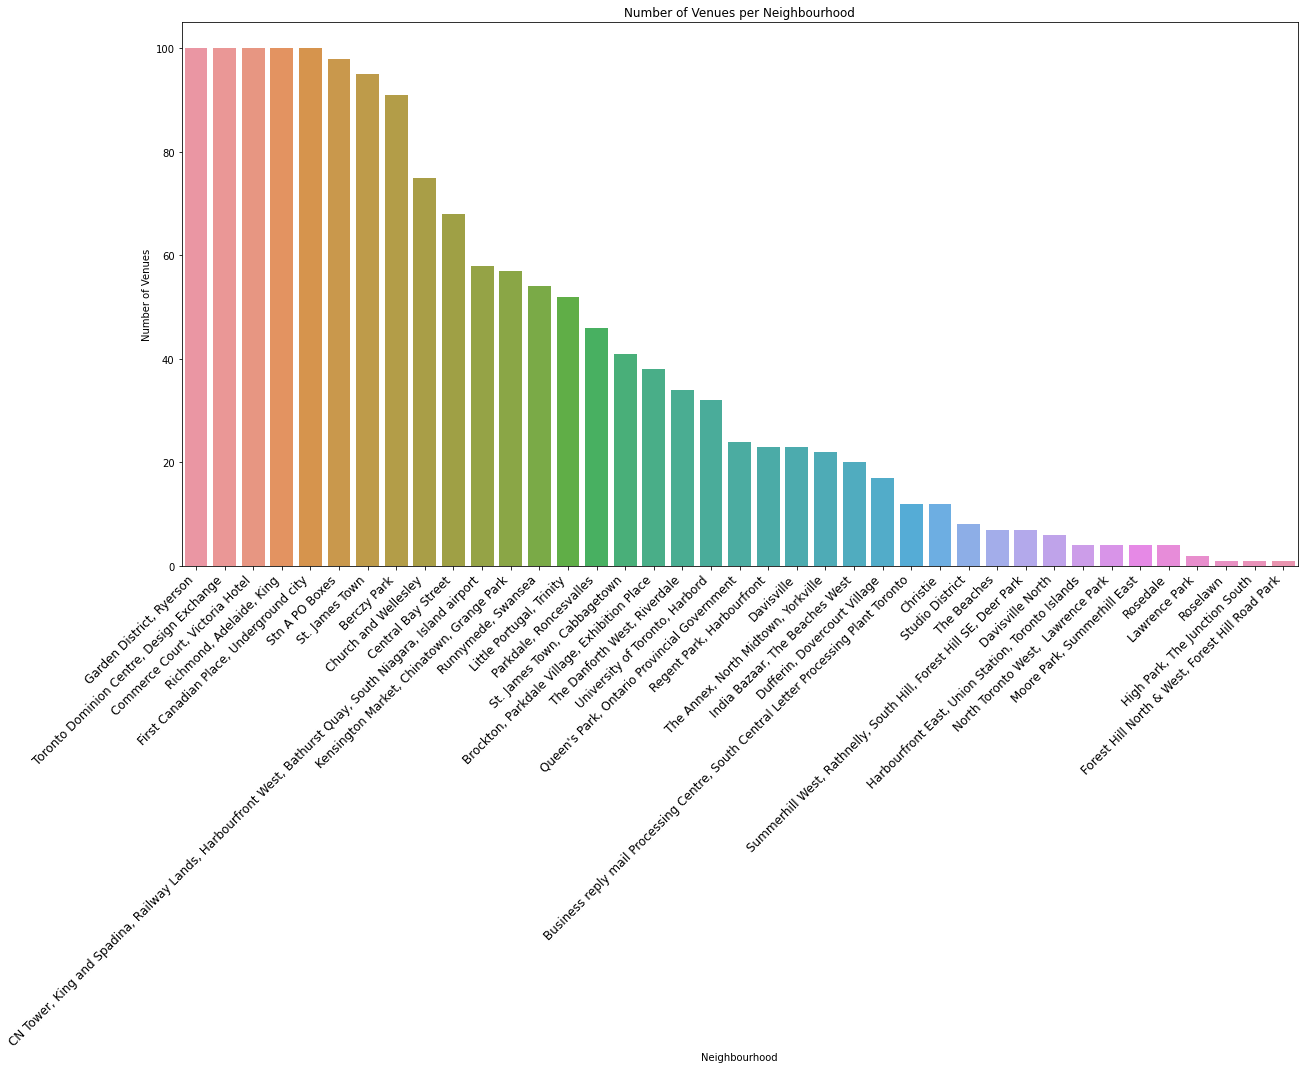

In [40]:
fig = plt.figure(figsize = (20,10))

ax = sns.barplot(x = count_df['Neighbourhood'], y = count_df['Venue'])

plt.xticks(rotation = 45, horizontalalignment='right', fontweight='light', fontsize='large')
plt.ylabel("Number of Venues")
plt.title("Number of Venues per Neighbourhood")

#### Cluster each Neighbourhood

In [41]:
toronto_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix = "", prefix_sep="")

In [42]:
toronto_onehot['Neighbourhood'] = downtown_venues['Neighbourhood']

In [43]:
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
toronto_grouped = toronto_onehot.groupby("Neighbourhood").mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0,0.010989,0.021978,0.000000,0.000000,0.000000,0.0,0.010989,...,0.0,0.010989,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.010989
1,"Brockton, Parkdale Village, Exhibition Place",0.026316,0.0,0.000000,0.026316,0.000000,0.026316,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.017241,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.017241,0.0,0.017241
4,Central Bay Street,0.000000,0.0,0.000000,0.000000,0.014706,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.014706,0.014706,0.0,0.014706,0.0,0.000000,0.0,0.000000


In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [46]:
toronto_grouped_clusetering = toronto_grouped.drop("Neighbourhood", axis = 1)

In [47]:
k = 5
k_means = KMeans(n_clusters = k, init = 'k-means++', n_init = 12).fit(toronto_grouped_clusetering)

In [48]:
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
k_means.cluster_centers_

array([[7.97448166e-04, 4.04040404e-04, 9.80850647e-03, ...,
        5.22466040e-04, 9.09090909e-04, 8.48847587e-03],
       [0.00000000e+00, 0.00000000e+00, 1.73472348e-18, ...,
        0.00000000e+00, 1.08420217e-19, 8.67361738e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [50]:
toronto_grouped.insert(1,'Cluster Labels', k_means.labels_)
toronto_grouped.head()

,Neighbourhood,Cluster Labels,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0,0.000000,0.0,0.010989,0.021978,0.000000,0.000000,0.000000,0.0,...,0.0,0.010989,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.010989
1,"Brockton, Parkdale Village, Exhibition Place",0,0.026316,0.0,0.000000,0.026316,0.000000,0.026316,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.017241,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.017241,0.0,0.017241
4,Central Bay Street,0,0.000000,0.0,0.000000,0.000000,0.014706,0.000000,0.000000,0.0,...,0.0,0.000000,0.014706,0.014706,0.0,0.014706,0.0,0.000000,0.0,0.000000


In [51]:
tor_df.insert(2,'Cluster Labels', k_means.labels_)
tor_df.head()

,Postal Code,Borough,Cluster Labels,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,0,"Regent Park, Harbourfront",43.6555,-79.3626
1,M7A,Downtown Toronto,0,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,M5B,Downtown Toronto,0,"Garden District, Ryerson",43.6572,-79.3783
3,M5C,Downtown Toronto,0,St. James Town,43.6513,-79.3756
4,M4E,East Toronto,0,The Beaches,43.6784,-79.2941


In [52]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.TileLayer('CartoDB dark_matter').add_to(map_clusters) # Sets Tile Theme to (Dark Theme)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Neighbourhood'], tor_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Finding the optimal k

In [53]:
from sklearn.metrics import silhouette_score

In [54]:
sil = []
kmax = 38

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    k_means = KMeans(n_clusters = k, init = 'k-means++', n_init = 20).fit(toronto_grouped_clusetering)
    labels = k_means.labels_
    sil.append(silhouette_score(toronto_grouped_clusetering, labels, metric = 'euclidean'))

sil[0:5]

[0.5101003225321622,
 0.5240610845814233,
 0.5383992748337266,
 0.31187495358075434,
 0.35922721279474057]

<function matplotlib.pyplot.show(*args, **kw)>

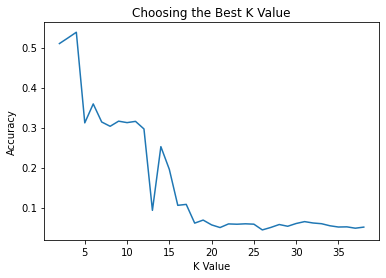

In [55]:
plt.plot(range(2,kmax+1), sil)
plt.title("Choosing the Best K Value")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.show

In [56]:
print( "The best accuracy was with", max(sil), "with k=", np.argmax(sil)+2) 

The best accuracy was with 0.5383992748337266 with k= 4


Since the most accurate model has 3 clusters, we will redo the clustering

In [57]:
k = np.argmax(sil)+2
k_means3 = KMeans(n_clusters = k, init = 'k-means++', n_init = 20).fit(toronto_grouped_clusetering)

In [58]:
k_means3.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
tor_df.drop('Cluster Labels', axis = 1, inplace = True)
tor_df.insert(2,'Cluster Labels', k_means3.labels_)
tor_df.head()

,Postal Code,Borough,Cluster Labels,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,0,"Regent Park, Harbourfront",43.6555,-79.3626
1,M7A,Downtown Toronto,0,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,M5B,Downtown Toronto,0,"Garden District, Ryerson",43.6572,-79.3783
3,M5C,Downtown Toronto,0,St. James Town,43.6513,-79.3756
4,M4E,East Toronto,0,The Beaches,43.6784,-79.2941


In [60]:
tor_df.groupby("Cluster Labels").count()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
Cluster Labels,,,,,
0,35,35,35,35,35
1,1,1,1,1,1
2,1,1,1,1,1
3,2,2,2,2,2


In [61]:
map_clusters_k_3 = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.TileLayer('CartoDB dark_matter').add_to(map_clusters_k_3) # Sets Tile Theme to (Dark Theme)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Neighbourhood'], tor_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_k_3)
       
map_clusters_k_3